In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier
from deap import base, creator, tools, algorithms
from scipy.stats.mstats import winsorize

Data import completed. The dimensions of the cleaned data are: (49331, 97)


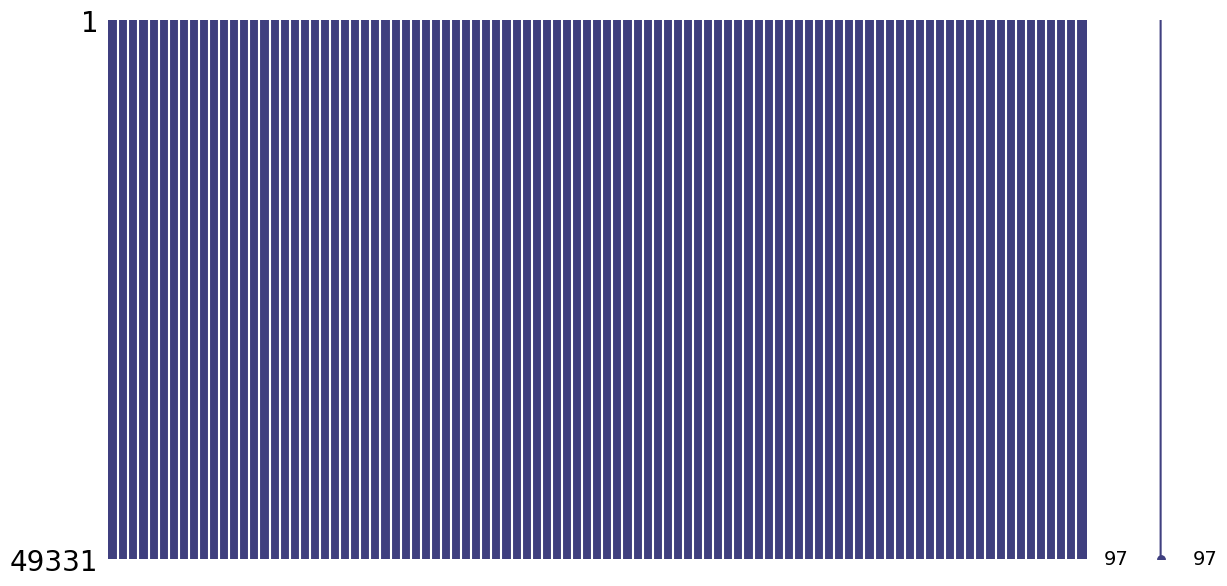

In [2]:
df = pd.read_csv("df_KNN-inpute.csv")
print(f"Data import completed. The dimensions of the cleaned data are: {df.shape}")
msno.matrix(df, figsize=(14, 7), color=(0.25, 0.25, 0.5))
plt.show()

In [3]:
numeric_features = df.select_dtypes(include=['float64']).columns
categorical_features = [col for col in df.columns if col not in numeric_features]

print(f"Categorical variables: {categorical_features}")
print(f"Numerical variables: {numeric_features}")

Categorical variables: ['id', 'hospital_mortality', 'aki_stage', 'gender', 'race_ASIAN', 'race_BLACK', 'race_HISPANIC', 'race_NATIVE_AMERICAN', 'race_OTHER', 'race_PACIFIC_ISLANDER', 'race_UNKNOWN', 'race_WHITE']
Numerical variables: Index(['admission_age', 'heart_rate_min', 'heart_rate_max', 'heart_rate_mean',
       'sbp_min', 'sbp_max', 'sbp_mean', 'dbp_min', 'dbp_max', 'dbp_mean',
       'mbp_min', 'mbp_max', 'mbp_mean', 'resp_rate_min', 'resp_rate_max',
       'resp_rate_mean', 'temperature_vital_min', 'temperature_vital_max',
       'temperature_vital_mean', 'spo2_min', 'spo2_max', 'spo2_mean',
       'glucose_vital_min', 'glucose_vital_max', 'glucose_vital_mean',
       'lactate_min', 'lactate_max', 'ph_min', 'ph_max', 'po2_min', 'po2_max',
       'pco2_min', 'pco2_max', 'baseexcess_min', 'baseexcess_max',
       'totalco2_min', 'totalco2_max', 'hematocrit_lab_min',
       'hematocrit_lab_max', 'hemoglobin_lab_min', 'hemoglobin_lab_max',
       'platelets_min', 'platelets_max', 

In [4]:
# Convert aki_stage to a binary classification (0/1)
df['aki_binary'] = df['aki_stage'].apply(lambda x: 0 if x == 0 else 1)

# Check the conversion result
print(df[['aki_stage', 'aki_binary']].head())
print(f"Data import completed. The dimensions of the cleaned data are: {df.shape}")

   aki_stage  aki_binary
0          0           0
1          0           0
2          0           0
3          0           0
4          2           1
Data import completed. The dimensions of the cleaned data are: (49331, 98)


In [6]:
# Define features (X) and two target variables (y1, y2)
X = df.drop(['id', 'hospital_mortality', 'aki_stage', 'aki_binary'], axis=1)
y1 = df['aki_binary']
y2 = df['aki_stage']

print(X.shape, y1.shape, y2.shape)

(49331, 94) (49331,) (49331,)


In [7]:
X = X.copy()

In [8]:
X['gender'] = X['gender'].astype('category')

print(X[['gender']].dtypes)

gender    category
dtype: object


In [9]:
# Get all One-Hot encoded race variables
race_columns = ['race_ASIAN', 'race_BLACK', 'race_HISPANIC', 'race_NATIVE_AMERICAN',
                'race_OTHER', 'race_PACIFIC_ISLANDER', 'race_UNKNOWN', 'race_WHITE']

# Convert these variables to 'category' type
for col in race_columns:
    X[col] = X[col].astype('category')

In [10]:
numeric_features = X.select_dtypes(include=['float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

print("Numerical variables:", numeric_features.tolist())
print("Categorical variables:", categorical_features.tolist())

Numerical variables: ['admission_age', 'heart_rate_min', 'heart_rate_max', 'heart_rate_mean', 'sbp_min', 'sbp_max', 'sbp_mean', 'dbp_min', 'dbp_max', 'dbp_mean', 'mbp_min', 'mbp_max', 'mbp_mean', 'resp_rate_min', 'resp_rate_max', 'resp_rate_mean', 'temperature_vital_min', 'temperature_vital_max', 'temperature_vital_mean', 'spo2_min', 'spo2_max', 'spo2_mean', 'glucose_vital_min', 'glucose_vital_max', 'glucose_vital_mean', 'lactate_min', 'lactate_max', 'ph_min', 'ph_max', 'po2_min', 'po2_max', 'pco2_min', 'pco2_max', 'baseexcess_min', 'baseexcess_max', 'totalco2_min', 'totalco2_max', 'hematocrit_lab_min', 'hematocrit_lab_max', 'hemoglobin_lab_min', 'hemoglobin_lab_max', 'platelets_min', 'platelets_max', 'wbc_min', 'wbc_max', 'aniongap_min', 'aniongap_max', 'bicarbonate_lab_min', 'bicarbonate_lab_max', 'bun_min', 'bun_max', 'calcium_lab_min', 'calcium_lab_max', 'chloride_lab_min', 'chloride_lab_max', 'creatinine_min', 'creatinine_max', 'glucose_lab_min', 'glucose_lab_max', 'sodium_lab_min

In [16]:
def winsorize_features(df, columns, limits=(0.03, 0.03)):  
    for col in columns:
        df[col] = winsorize(df[col], limits=limits)
    return df

numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
X = winsorize_features(X, numeric_features, limits=(0.03, 0.03))
print("Winsorization processing completed")

Winsorization processing completed


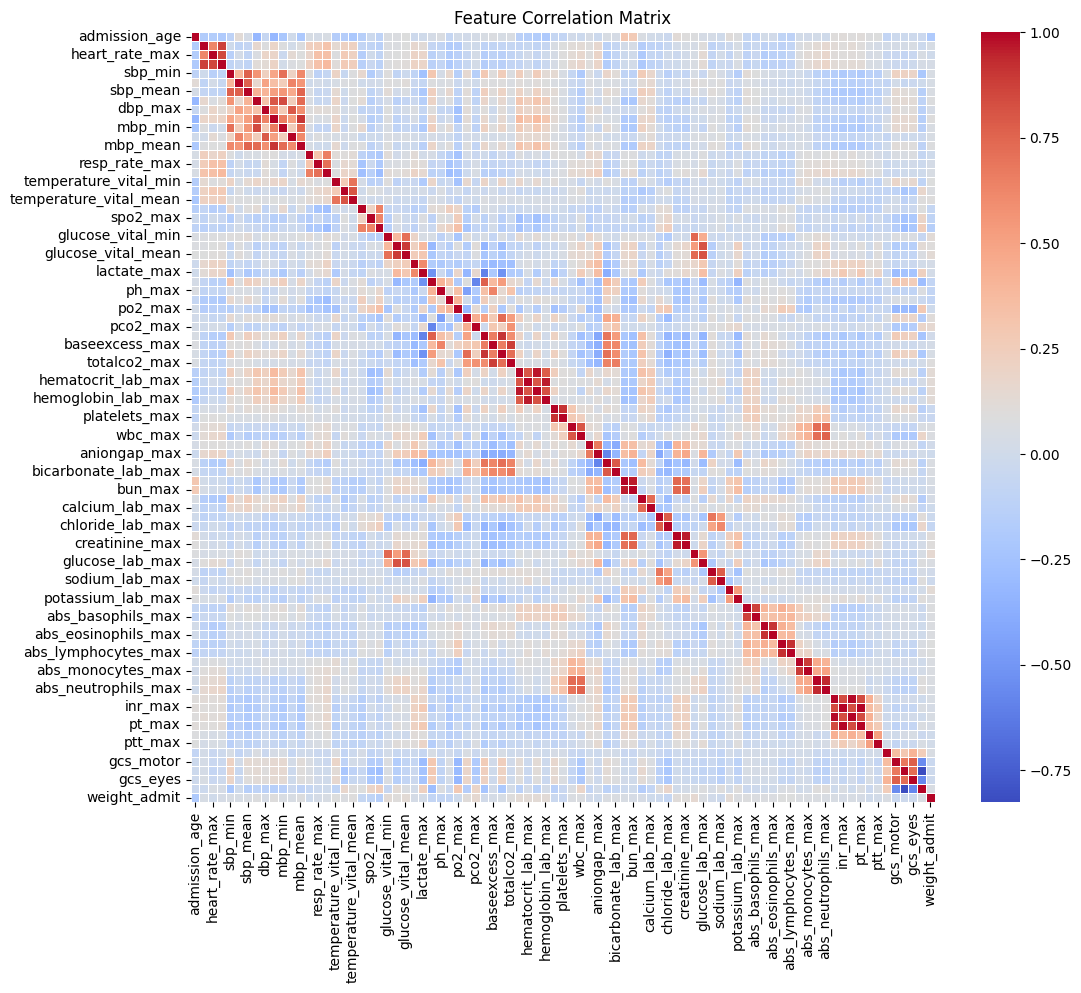

 Number of highly correlated features to remove: 24
 List of features to remove: ['glucose_vital_mean', 'abs_basophils_max', 'hemoglobin_lab_min', 'mbp_min', 'abs_lymphocytes_max', 'gcs_unable', 'platelets_max', 'abs_eosinophils_max', 'inr_max', 'totalco2_min', 'heart_rate_mean', 'hematocrit_lab_max', 'mbp_mean', 'pt_min', 'glucose_lab_max', 'hemoglobin_lab_max', 'bun_max', 'pt_max', 'temperature_vital_mean', 'abs_neutrophils_max', 'totalco2_max', 'abs_monocytes_max', 'creatinine_max', 'wbc_max']
 New data shape: (49331, 70)


In [12]:
# Select only numerical variables (float64 and int64), excluding already converted categorical variables
numeric_features = X.select_dtypes(include=['float64']).columns
corr_matrix = X[numeric_features].corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

# Compute the absolute correlation matrix
corr_matrix = corr_matrix.abs()

# Set correlation threshold
threshold = 0.80

# Identify highly correlated feature pairs (excluding self-correlation of 1.0)
high_corr_pairs = np.where(corr_matrix > threshold)
high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_pairs) if x != y and x < y]

# Features to be dropped (removing one feature from each pair)
drop_cols = list(set([pair[1] for pair in high_corr_pairs]))

# Print information
print(f" Number of highly correlated features to remove: {len(drop_cols)}")
print(f" List of features to remove: {drop_cols}")

# Drop highly correlated features
X.drop(columns=drop_cols, inplace=True)

# Confirm data shape
print(f" New data shape: {X.shape}")


In [13]:
#Recompute numerical features to ensure removed features are not in the list**
numeric_features = X.select_dtypes(include=['float64']).columns  # Recalculate

#Normalize using RobustScaler (continue processing on X)**
scaler = RobustScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])
print(" Normalization completed")


 Normalization completed


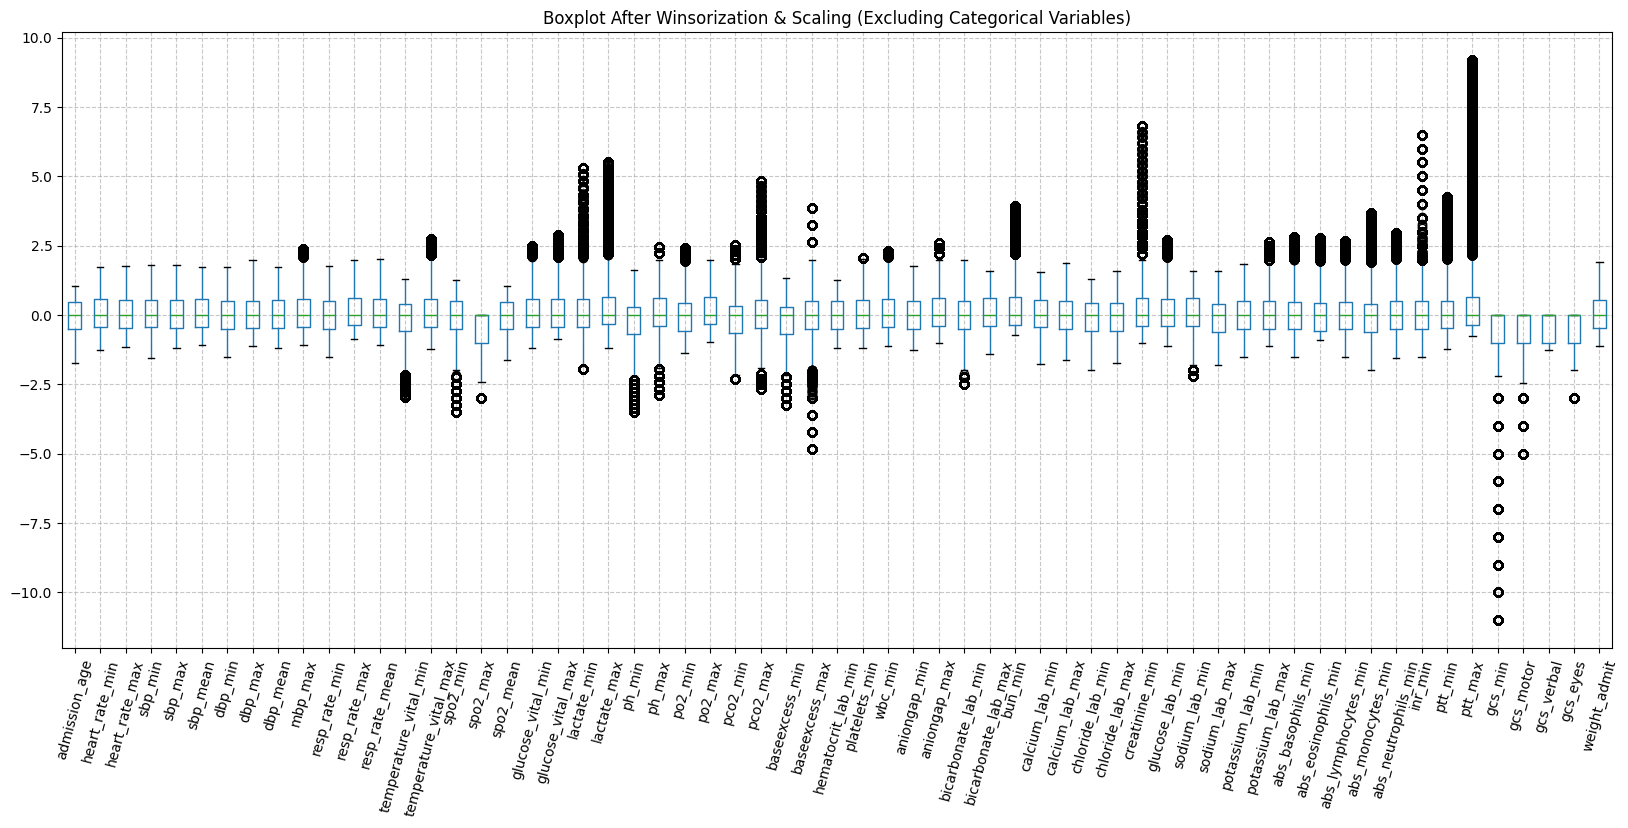

In [14]:
plt.figure(figsize=(20, 8))
X[numeric_features].boxplot(rot=75)
plt.title("Boxplot After Winsorization & Scaling (Excluding Categorical Variables)")
plt.xticks(rotation=75)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

In [15]:
def save_processed_data(X, y, column_name, filename, remove_columns=None):
    X = X.copy()  # Avoid modifying the original X
    if remove_columns:
        X.drop(columns=remove_columns, errors="ignore", inplace=True)  # Remove specified columns
    
    X[column_name] = y  # Add target variable
    X.to_csv(filename, index=False)  # Keep index to avoid confusion when reloading
    print(f" Processed X data has been saved as '{filename}'")
    print(f" New data shape: {X.shape}")

# Save aki_binary first
save_processed_data(X, y1, "aki_binary", "X+aki_binary-corr.csv")

# Save aki_stage while removing aki_binary
save_processed_data(X, y2, "aki_stage", "X+aki_stage-corr.csv", remove_columns=["aki_binary"])

 Processed X data has been saved as 'X+aki_binary-corr.csv'
 New data shape: (49331, 71)
 Processed X data has been saved as 'X+aki_stage-corr1.csv'
 New data shape: (49331, 71)
